# 单发多框检测SSD
在多个分辨率下的预测bounding-box并预测类别

图片 -> 基础网络块base_blk -> 多个增加通道数，但是可以使图片长宽减半的sample_down_blk
后面两步的blk都能做 类别预测 和 边界框预测

## 基础：多尺度目标检测

In [1]:
import matplotlib.pyplot as plt
import torch
import My_utils

img = plt.imread('./img/catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

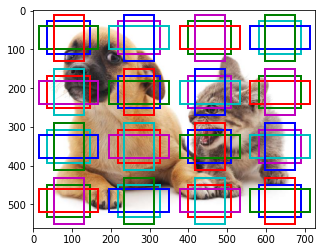

In [2]:
# 在特征图上以每个像素为中心生成不同size的锚框的函数
def display_anchors(fmap_h, fmap_w, s):
    """
    :param fmap_h: 特征图的高度，在竖直上画的框的数量
    :param fmap_w: 特征图的宽度，在水平上画的框的数量
    :param s: size的集合
    """
    My_utils.set_figsize()
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = My_utils.anchor_boxes(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    My_utils.show_bbox(plt.imshow(img).axes, anchors[0] * bbox_scale)


display_anchors(4, 4, [0.15])

## SSD的实现

In [3]:
import torch
from torch import nn
import torchvision
from torch.nn import functional as F
import matplotlib.pyplot as plt
import My_utils

In [4]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), My_utils.class_predictor(8, 5, 10))
# 图片20像素*20像素，每个像素生成5个锚框，对十个类别进行预测，因此共20 * 20 * 5 * (10 + 1)
Y2 = forward(torch.zeros((2, 16, 10, 10)), My_utils.class_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [5]:
My_utils.concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [6]:
forward(torch.zeros((2, 3, 20, 20)), My_utils.down_sample_blk(3, 10)).shape  # 高宽减半的Conv2d

torch.Size([2, 10, 10, 10])